<a href="https://colab.research.google.com/github/Beees835/Deep-Learning/blob/main/FIT3181_5215_Kaggle_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4: CNN and Kaggle competition

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [1]:
!gdown https://drive.google.com/file/d/1AQ4tusHvPgu09zn-j7rsvD_739OJtiGp/view?usp=sharing --fuzzy

# backup url, uncomment one of url links if needed
# !gdown https://drive.google.com/file/d/17X-7MYKo2TxOmDlvoLnDlD52Bb6dVi9h/view?usp=sharing --fuzzy # backup url1
# !gdown https://drive.google.com/file/d/1oF0LXhVUzG72JUyB7Uikj3RI_eDiwShb/view?usp=sharing --fuzzy #backup url2
# !gdown https://drive.google.com/file/d/1gLb13BuUc5HM3CFI2d228jxUJKnJ49Ed/view?usp=sharing --fuzzy # backup url3

Downloading...
From (original): https://drive.google.com/uc?id=1AQ4tusHvPgu09zn-j7rsvD_739OJtiGp
From (redirected): https://drive.google.com/uc?id=1AQ4tusHvPgu09zn-j7rsvD_739OJtiGp&confirm=t&uuid=5657b4c2-3de3-4375-ac2d-5fba646aee98
To: /content/data_kaggle_week4.zip
100% 303M/303M [00:01<00:00, 234MB/s]


In [2]:
!unzip -q __MACOSX/._data_kaggle_week4

replace __MACOSX/._data_kaggle_week4? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import torch
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from data_kaggle_week4.dataweek4 import WEEK4

In [5]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(1029)

## Data Preprocess

In [36]:
## data augmentation
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                     transforms.Resize((96,96)),  #resises the image so it can be perfect for our model.
                                     ])

train_transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [37]:
dataset = WEEK4(root='data_kaggle_week4', transform=ToTensor())
test_dataset = WEEK4(root='data_kaggle_week4', split ='test', transform=ToTensor())

In [38]:
dataset_size = len(dataset)
train_ds = dataset
print('Train info', dataset_size, train_ds.data.shape)

test_dataset_size = len(test_dataset)
print('Test info: ', test_dataset_size)

classes = dataset.classes
print('Class info: ', dataset.classes)

Train info 5000 (5000, 3, 96, 96)
Test info:  8000
Class info:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Label (numeric): 1
Label (textual): bird


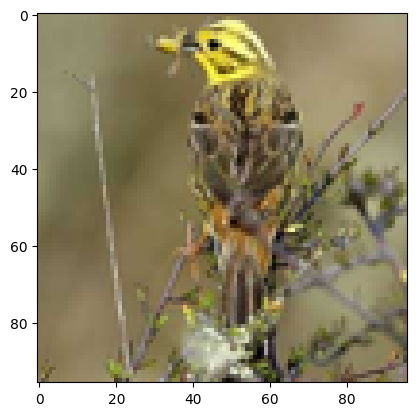

In [39]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [40]:
count_class = {}
for _,outs in dataset:
    labels = classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'bird': 500,
 'dog': 500,
 'horse': 500,
 'cat': 500,
 'truck': 500,
 'monkey': 500,
 'deer': 500,
 'ship': 500,
 'airplane': 500,
 'car': 500}

### Data Split

In [41]:
val_size = 1000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4000, 1000)

#### Data Loader

In [42]:
batch_size=32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

#### Examples

images.shape: torch.Size([32, 3, 96, 96])


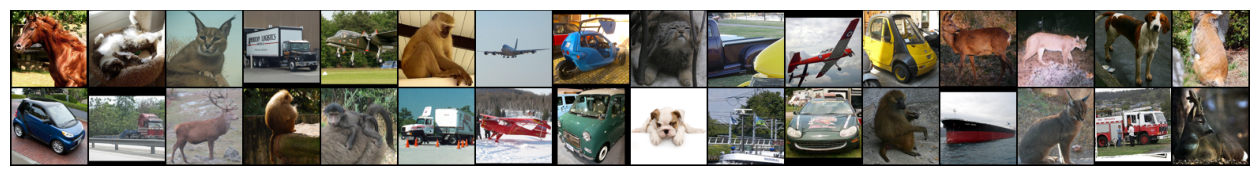

In [43]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Define Models

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [45]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

In [46]:
import time
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True):
  # Move the model to the device before initializing the optimizer
  model.to(device)
  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
      start = time.time()
      model.train()
      for (X, y) in train_loader:
          # Move input data to the same device as the model
          X,y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      end = time.time()
      print(f"total time for each epoch {end - start}") # time in seconds
      if not verbose: #verbose = True means we do show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [49]:
class CnnModel(nn.Module):
	def __init__(self, num_classes=10):
		super().__init__()
		self.network = nn.Sequential(
			nn.Conv2d(3, 16, kernel_size=3, padding=1), # Reduced channels from 32 to 16
			nn.ReLU(),
			nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # Reduced channels from 64 to 32
			nn.ReLU(),
			nn.MaxPool2d(2, 2),

			nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Reduced channels from 128 to 64
			nn.ReLU(),
			nn.MaxPool2d(2, 2),

			nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Reduced channels from 256 to 128
			nn.ReLU(),
			nn.MaxPool2d(2, 2),
			nn.Flatten(),
			nn.Linear(128*6*6, 512), # Reduced neurons from 1024 to 512
			nn.ReLU(),
			nn.Linear(512, num_classes)) # Removed one linear layer

	def forward(self, xb):
		return self.network(xb)

	def forward(self, xb):
		return self.network(xb)


def conv_block(in_channels, out_channels, pool=False):
	layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
			  nn.BatchNorm2d(out_channels),
			  nn.ReLU(inplace=True)]
	if pool: layers.append(nn.MaxPool2d(2))
	return nn.Sequential(*layers)

class ResNet9(nn.Module):
	def __init__(self, in_channels=3, num_classes=10):
		super().__init__()

		self.conv1 = conv_block(in_channels, 64,pool=True)
		self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
		self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

		self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
		self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
		self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

		self.classifier = nn.Sequential(
    nn.MaxPool2d(6),
    nn.Flatten(),
    nn.Dropout(0.5),  # Increased dropout rate
    nn.Linear(512, num_classes))

	def forward(self, xb):
		out = self.conv1(xb)
		out = self.conv2(out)
		out = self.res1(out) + out
		out = self.conv3(out)
		out = self.conv4(out)
		out = self.res2(out) + out
		out = self.classifier(out)
		return out

class MiniVGG(nn.Module):
	def __init__(self, num_classes=10):
		super().__init__()
		layers = []
		layers.append(nn.Conv2d(3, 16, kernel_size=3, padding= 1)) #[32,32,32]
		layers.append(nn.BatchNorm2d(16))
		layers.append(nn.ReLU(inplace=True))
		#nn.LazyConv2d(32, kernel_size=3, padding=1),
		layers.append(nn.Conv2d(16, 16, kernel_size=3, padding=1)) #[32,32,32]
		layers.append(nn.BatchNorm2d(16))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.MaxPool2d(kernel_size=2)) #down-sample by two #[32,16,16]
		layers.append(nn.Dropout(p=0.25))
		#nn.LazyConv2d(64, kernel_size=3, padding=1),
		layers.append(nn.Conv2d(16, 32 , kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(32))
		layers.append(nn.ReLU(inplace = True))
		#nn.LazyConv2d(64, kernel_size=3, padding=1)
		layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(32))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1)) #[64,16,16]
		layers.append(nn.BatchNorm2d(32))
		layers.append(nn.ReLU(inplace= True)),
		layers.append(nn.MaxPool2d(kernel_size=2)), #down-sample by two [64,8,8]
		layers.append(nn.Dropout(p=0.25))
		layers.append(nn.Flatten(1)) #64x8x8
		layers.append(nn.LazyLinear(256))
		layers.append(nn.ReLU(inplace = True))
		layers.append(nn.LazyLinear(num_classes))
		self.block = nn.ModuleList(layers)
	def forward(self,x):
		for layer in self.block:
			x = layer(x)
		return x

## Training the Model

### Model Selection

In [53]:
 model = ResNet9().to(device)
# model = MiniVGG(10).to(device)
# model = CnnModel().to(device)

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [ ]:
from torch import optim
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


# Loss and optimizer
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = optim_dict["RMSprop"](model.parameters(), lr=learning_rate)

#dnn_model = model
history = fit(model=model, train_loader=train_loader, valid_loader = valid_loader,
    optimizer = optimizer, num_epochs= 5, verbose = False)

#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'r--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

# Evaluate model on the testing set, get the csv file and upload to kaggle website.

In [ ]:
import torch
import pandas as pd

def save_prediction_to_csv(model, loader, device, output_file="submission.csv"):
    model.eval()
    predictions = []
    image_ids = []
    df = {
    "ImageId": [],
    "Label": []
    }
    total = 0
    with torch.no_grad():
        for i, (batchX, batchY) in enumerate(loader):
            batchX, batchY = batchX.to(device), batchY.to(device)
            outputs = model(batchX.float())  # Convert to float32 and feed batch to the model
            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class
            total += predicted.size(0)
            for ids, pred in enumerate(predicted):
                df["Label"].append(pred.cpu().item())
    df["ImageId"] = [i+1 for i in range(total)]
    # Create a DataFrame
    df = pd.DataFrame(df)
    # Save to CSV
    df.to_csv(output_file, index=False)

In [ ]:
save_prediction_to_csv(model, test_loader, device)

# Upload result to kaggle competition

## Regsiter Kaggle account using your private gmail
## Join the competition via Link on Moodle
## Upload the submission.csv file to the kaggle website to get your results

## Rules

*   No late submissions are allowed.
*   Students must compete in groups. Only group scores shown on Kaggle that count.
